## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [11]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [12]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [13]:
text[1]

"  That thereby beauty's rose might never die,\n"

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [14]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2022-12-26 21:59:40--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Распознаётся squid.lvsi.loc (squid.lvsi.loc)… 192.168.10.1
Подключение к squid.lvsi.loc (squid.lvsi.loc)|192.168.10.1|:3128... соединение установлено.
Proxy-запрос отправлен. Ожидание ответа… 200 OK
Длина: 262521 (256K) [text/plain]
Сохранение в: «onegin.txt.2»

onegin.txt.2        100%[===================>] 256,37K  1,20MB/s    за 0,2s    

2022-12-26 21:59:41 (1,20 MB/s) - «onegin.txt.2» сохранён [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [15]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text = ''.join(text).lower()
# Your great code here


In [53]:
sentences = text.split('\n')
print('Total sequences: ', len(sentences))

7089


max length = 158


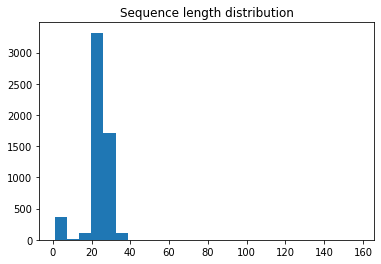

In [83]:
MAX_LENGTH = max(map(len, sentences))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, sentences)),bins=25);

Избавимся от аномально-длинные последовательности

In [84]:
MAX_LENGTH = 45
sentences = [s for s in sentences if 0 < len(s) < 45]
len(sentences)

5610

Put all the characters, that you've seen in the text, into variable `tokens`.

In [85]:
tokens = sorted(set(text))

In [86]:
print(tokens)

['\n',
 ' ',
 '!',
 '(',
 ')',
 ',',
 '-',
 '.',
 '5',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '[',
 ']',
 '^',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '«',
 '»',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 '–',
 '—',
 '’',
 '…',
 '€']

In [90]:
tokens.append('<')
tokens.append('>')
tokens.append('_')

In [141]:
num_tokens = len(tokens)
print('Num tokens: ', num_tokens)

Num tokens:  86


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [92]:
# dict <index>:<char>
# Your great code here
idx_to_token = {i: tok for i, tok in enumerate(tokens)}
token_to_idx = {tok: i for i, tok in enumerate(tokens)}

# dict <char>:<index>
# Your great code here

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [94]:
# Your code here

In [95]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [99]:
def to_matrix(sentences, max_len=None, pad=token_to_idx['_'], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, sentences))
    max_len += 1
    sentences_ix = np.zeros([len(sentences), max_len], dtype) + pad

    sentences_ix[:, 0] = token_to_idx['<']

    for i in range(len(sentences)):
        line_ix = [token_to_idx[c] for c in sentences[i]]
        sentences_ix[i, 1:len(line_ix)] = line_ix[1:]
        sentences_ix[i, len(line_ix)] = token_to_idx['>']

    if not batch_first: # convert [batch, time] into [time, batch]
        sentences_ix = np.transpose(names_ix)

    return sentences_ix

In [100]:
print('\n'.join(sentences[::2000]))
print(to_matrix(sentences[::2000]))

i
«ах, няня, няня! до того ли?
за все, за все твои дары;
[[83 84 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
  85 85 85 85 85]
 [83 45 66  5  1 58 76 58 76  5  1 58 76 58 76  2  1 49 59  1 63 59 48 59
   1 56 53 14 84]
 [83 45  1 47 62 50  5  1 52 45  1 47 62 50  1 63 47 59 53  1 49 45 61 72
  13 84 85 85 85]]


In [101]:
import matplotlib.pyplot as plt

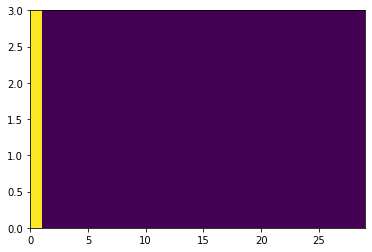

In [102]:
plt.pcolormesh(to_matrix(sentences[::2000]) == token_to_idx['<'])

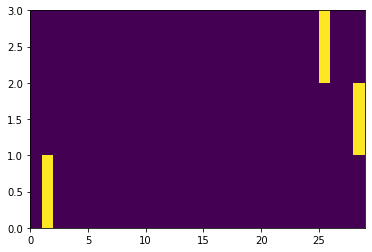

In [103]:
plt.pcolormesh(to_matrix(sentences[::2000]) == token_to_idx['>'])

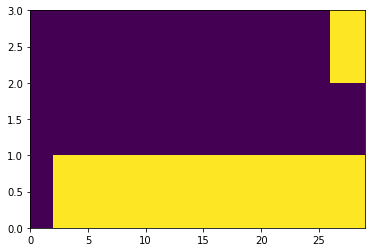

In [104]:
plt.pcolormesh(to_matrix(sentences[::2000]) == token_to_idx['_'])

In [105]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = torch.tanh(h_next) #YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) #YOUR CODE
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [106]:
char_rnn = CharRNNCell()

In [107]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logits.append(logits_next)
        
    return torch.stack(logits, dim=1)

In [112]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx['_'])


Plot the loss function (axis X: number of epochs, axis Y: loss function).

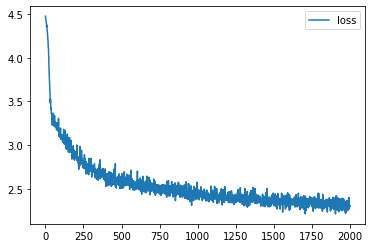

In [113]:
MAX_LENGTH = 45

for i in range(2000):
    batch_ix = to_matrix(sample(sentences, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logits_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    #<YOUR CODE>
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = loss_func(predictions_logits.reshape(-1, num_tokens), actual_next_tokens.reshape(-1))

    # train with backprop

    opt.zero_grad()
    loss.backward()    
    opt.step()
    #<YOUR CODE>
    
    history.append(loss.item())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [3]:
# Your plot code here

In [129]:
def generate_sample(char_rnn, seed_phrase='<', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    char_rnn.eval()
    with torch.no_grad():
        x_sequence = [token_to_idx[token] for token in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
        hid_state = char_rnn.initial_state(batch_size=1)
        
        #feed the seed phrase, if any
        for i in range(len(seed_phrase) - 1):
            hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
        
        #start generating
        for _ in range(max_length - len(seed_phrase)):
            hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)
            p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]
            
            # sample next token and push it back into x_sequence
            next_ix = np.random.choice(num_tokens,p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)
            if next_ix == token_to_idx['>']:
                break
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][1:-1]])

Сгенерируем последовательности:

In [130]:
for _ in range(10):
    print(generate_sample(char_rnn))

ав скольсне дувналетнегось
лид ве мышия вне весенст вык пакрепось ря!,
епилин; остраскала.,
 – «буне кож!
вому непрережириний труст искосльно нибумя 
 стонать остас блучаной он иналя дерту ното
хрува бножнорна…
 мобе сних умурьски взиждом бодой
нежат.
v


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [46]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [47]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [4]:
# Saving and loading code here

In [159]:
char_rnn

CharRNNCell(
  (embedding): Embedding(86, 16)
  (rnn_update): Linear(in_features=80, out_features=64, bias=True)
  (rnn_to_logits): Linear(in_features=64, out_features=86, bias=True)
)

In [160]:
torch.save(char_rnn.state_dict(), 'model_weights.pth')

In [161]:
model = CharRNNCell() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [162]:
for _ in range(10):
    print(generate_sample(model))

десто взе кравелн.
о всё нак посветья свовы выный-ругрушь.
то на блdвовит неты слудно насяргцась свден
 о в холго уповкру
етре вак робкатью двих колела серростей
ладик бижи
 слад осмиру говаль рась
 в на мол музном полил адо погде сечим осне
 шам шугсю гуят своостилой шушьки селел
о ненжи грисстроготляго


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)